In [1]:
import random
import time
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
from run import utils

C:\Users\lucas\anaconda3\envs\neuromancer\lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


## 60x4 Rosenbrock

In [2]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# init
steepness = 50    # steepness factor
num_blocks = 30   # number of expression blocks
num_data = 9100   # number of data
test_size = 100   # number of test size
val_size = 1000   # number of validation size
train_size = num_data - test_size - val_size

# parameters as input data
p_low, p_high = 1.0, 8.0
a_low, a_high = 0.5, 4.5
p_train = np.random.uniform(p_low, p_high, (train_size, 1)).astype(np.float32)
p_test  = np.random.uniform(p_low, p_high, (test_size, 1)).astype(np.float32)
p_dev   = np.random.uniform(p_low, p_high, (val_size, 1)).astype(np.float32)
a_train = np.random.uniform(a_low, a_high, (train_size, num_blocks)).astype(np.float32)
a_test  = np.random.uniform(a_low, a_high, (test_size, num_blocks)).astype(np.float32)
a_dev   = np.random.uniform(a_low, a_high, (val_size, num_blocks)).astype(np.float32)

# nm datasets
from neuromancer.dataset import DictDataset
data_train = DictDataset({"p":p_train, "a":a_train}, name="train")
data_test = DictDataset({"p":p_test, "a":a_test}, name="test")
data_dev = DictDataset({"p":p_dev, "a":a_dev}, name="dev")
# torch dataloaders
from torch.utils.data import DataLoader
batch_size = 64
loader_train = DataLoader(data_train, batch_size, num_workers=0, collate_fn=data_train.collate_fn, shuffle=True)
loader_test = DataLoader(data_test, batch_size, num_workers=0, collate_fn=data_test.collate_fn, shuffle=False)
loader_dev = DataLoader(data_dev, batch_size, num_workers=0, collate_fn=data_dev.collate_fn, shuffle=True)

# init model
from src.problem import msRosenbrock
model = msRosenbrock(steepness, num_blocks, timelimit=600)

In [4]:
# get a & p
a = data_test.datadict["a"][0]
p = data_test.datadict["p"][0]

### Rounding Classification

In [5]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [6]:
# hyperparameters
penalty_weight = 100   # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 32            # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

# set problem
import neuromancer as nm
from src.problem import nmRosenbrock
from src.func.layer import netFC
from src.func import roundGumbelModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_blocks+1, outsize=2*num_blocks, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["p", "a"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=3*num_blocks+1, hidden_dims=[hsize]*hlayers_rnd, output_dim=2*num_blocks)
rnd = roundGumbelModel(layers=layers_rnd, param_keys=["p", "a"], var_keys=["x"],  output_keys=["x_rnd"], 
                       int_ind=model.int_ind, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = nmRosenbrock(["p", "a", "x_rnd"], steepness, num_blocks, penalty_weight)

from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_dev)

Epoch 0, Iters 0, Validation Loss: 6780.60
Epoch 0, Iters 125, Training Loss: 4337.39, Validation Loss: 1163.32
Epoch 1, Iters 250, Training Loss: 981.50, Validation Loss: 534.00
Epoch 2, Iters 375, Training Loss: 681.73, Validation Loss: 413.20
Epoch 3, Iters 500, Training Loss: 560.61, Validation Loss: 368.43
Epoch 4, Iters 625, Training Loss: 486.96, Validation Loss: 344.12
Epoch 5, Iters 750, Training Loss: 428.54, Validation Loss: 327.86
Epoch 6, Iters 875, Training Loss: 390.19, Validation Loss: 292.51
Epoch 7, Iters 1000, Training Loss: 353.11, Validation Loss: 287.04
Epoch 8, Iters 1125, Training Loss: 320.51, Validation Loss: 234.69
Epoch 9, Iters 1250, Training Loss: 339.66, Validation Loss: 259.89
Epoch 10, Iters 1375, Training Loss: 303.92, Validation Loss: 229.86
Epoch 11, Iters 1500, Training Loss: 287.98, Validation Loss: 253.35
Epoch 12, Iters 1625, Training Loss: 274.96, Validation Loss: 203.50
Epoch 13, Iters 1750, Training Loss: 261.81, Validation Loss: 206.09
Epoch 

In [7]:
# init proj
from src.postprocess.project import gradientProjection
proj = gradientProjection([components[0]], [components[1]], loss_fn, "x")
# data point as tensor
datapoints = {"p": torch.tensor(np.array([p]), dtype=torch.float32).to("cuda"), 
              "a": torch.tensor(np.array([a]), dtype=torch.float32).to("cuda"),
              "name": "test"}
# infer
components.eval()
tick = time.time()
with torch.no_grad():
    for comp in components:
        datapoints.update(comp(datapoints))
proj(datapoints)
tock = time.time()
elapsed = tock - tick
# assign params
model.set_param_val({"a":a, "p":p})
# assign vars
x = datapoints["x_rnd"]
for i in range(num_blocks*2):
    model.vars["x"][i].value = x[0,i].item()
# get solutions
xval, objval = model.get_val()
viol = np.mean(model.cal_violation())
print(f"Obj: {objval:.4f} with {viol:.4f} violation in {elapsed:.4f} sec.")

Obj: 56.9038 with 0.0000 violation in 0.0178 sec.


### Learnable Threshold

In [8]:
# random seed
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed(2)

In [9]:
# hyperparameters
penalty_weight = 100   # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 32            # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

# set problem
import neuromancer as nm
from src.problem import nmRosenbrock
from src.func.layer import netFC
from src.func import roundThresholdModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_blocks+1, outsize=2*num_blocks, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["p", "a"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=3*num_blocks+1, hidden_dims=[hsize]*hlayers_rnd, output_dim=2*num_blocks)
rnd = roundThresholdModel(layers=layers_rnd, param_keys=["p", "a"], var_keys=["x"],  output_keys=["x_rnd"], 
                          int_ind=model.int_ind, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = nmRosenbrock(["p", "a", "x_rnd"], steepness, num_blocks, penalty_weight)

from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_dev)

Epoch 0, Iters 0, Validation Loss: 6946.15
Epoch 0, Iters 125, Training Loss: 3987.20, Validation Loss: 1073.50
Epoch 1, Iters 250, Training Loss: 606.56, Validation Loss: 390.08
Epoch 2, Iters 375, Training Loss: 419.86, Validation Loss: 328.54
Epoch 3, Iters 500, Training Loss: 358.93, Validation Loss: 275.75
Epoch 4, Iters 625, Training Loss: 320.48, Validation Loss: 278.85
Epoch 5, Iters 750, Training Loss: 281.55, Validation Loss: 239.20
Epoch 6, Iters 875, Training Loss: 264.85, Validation Loss: 273.20
Epoch 7, Iters 1000, Training Loss: 258.59, Validation Loss: 219.72
Epoch 8, Iters 1125, Training Loss: 233.55, Validation Loss: 187.66
Epoch 9, Iters 1250, Training Loss: 224.68, Validation Loss: 205.26
Epoch 10, Iters 1375, Training Loss: 211.52, Validation Loss: 184.95
Epoch 11, Iters 1500, Training Loss: 201.31, Validation Loss: 182.61
Epoch 12, Iters 1625, Training Loss: 199.08, Validation Loss: 184.75
Epoch 13, Iters 1750, Training Loss: 198.46, Validation Loss: 187.65
Epoch 

In [10]:
# init proj
from src.postprocess.project import gradientProjection
proj = gradientProjection([components[0]], [components[1]], loss_fn, "x")
# data point as tensor
datapoints = {"p": torch.tensor(np.array([p]), dtype=torch.float32).to("cuda"), 
              "a": torch.tensor(np.array([a]), dtype=torch.float32).to("cuda"),
              "name": "test"}
# infer
components.eval()
tick = time.time()
with torch.no_grad():
    for comp in components:
        datapoints.update(comp(datapoints))
proj(datapoints)
tock = time.time()
elapsed = tock - tick
# assign params
model.set_param_val({"a":a, "p":p})
# assign vars
x = datapoints["x_rnd"]
for i in range(num_blocks*2):
    model.vars["x"][i].value = x[0,i].item()
# get solutions
xval, objval = model.get_val()
viol = np.mean(model.cal_violation())
print(f"Obj: {objval:.4f} with {viol:.4f} violation in {elapsed:.4f} sec.")

Obj: 104.9263 with 0.0000 violation in 0.0056 sec.


### Exact Solver

In [11]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [12]:
# set coeff
model.set_param_val({"a":a, "p":p})
# solve
xval, objval = model.solve("gurobi", tee=True, keepfiles=True)

Solver log file: 'C:\Users\lucas\AppData\Local\Temp\tmpx1sd5gdc_scip.log'
Solver solution file: 'C:\Users\lucas\AppData\Local\Temp\tmphzutp9fa.pyomo.sol'
Solver problem files: ('C:\\Users\\lucas\\AppData\\Local\\Temp\\tmphzutp9fa.pyomo.nl',)
SCIP version 8.1.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 6.0.4] [GitHash: 6129793871]
Copyright (c) 2002-2023 Zuse Institute Berlin (ZIB)

External libraries: 
  Soplex 6.0.4         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 950b1658]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.13          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  AMPL/MP 4e2d45c4     AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.1.4         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) [GitHash: ee0677c4]
  bliss 0.77           Computing

#### Plot

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
cset =  tc.tol_cset("medium-contrast")

In [2]:
def plotObj(times, objs):
    # prepare data for step-like plot
    time_steps = []
    obj_steps = []
    for i in range(len(times)):
        if i > 0:
            time_steps.append(times[i])  # add the current time
            obj_steps.append(objs[i - 1])  # previous obj value
        time_steps.append(times[i])  # add the current time
        obj_steps.append(objs[i])  # current obj value
    # create a plot
    fig, ax = plt.subplots(figsize=(8, 4))
    # plot step-like behavior
    ax.step(time_steps, obj_steps, where="post", linewidth=4, color=cset.light_yellow, label="EX (SCIP)")
    ax.scatter(0.0178, 56.9038, s=200, color=cset.dark_blue, label="RC-P", zorder=8)
    ax.scatter(0.0056, 104.9263, s=200, color=cset.dark_red, label="LT-P", zorder=8)
    plt.tight_layout()
    # Customize the plot
    ax.set_title("A 60×4 Mixed-Integer Rosenbrock Instance", fontsize=36)
    ax.set_xlabel("Time (Second)", fontsize=32)
    ax.set_ylabel("Objective Value", fontsize=32)
    ax.tick_params(axis="both", labelsize=24)
    ax.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    ax.legend(title="Method", fontsize=24, title_fontsize=24)
    plt.savefig("./img/solving_rb.pdf", dpi=300)

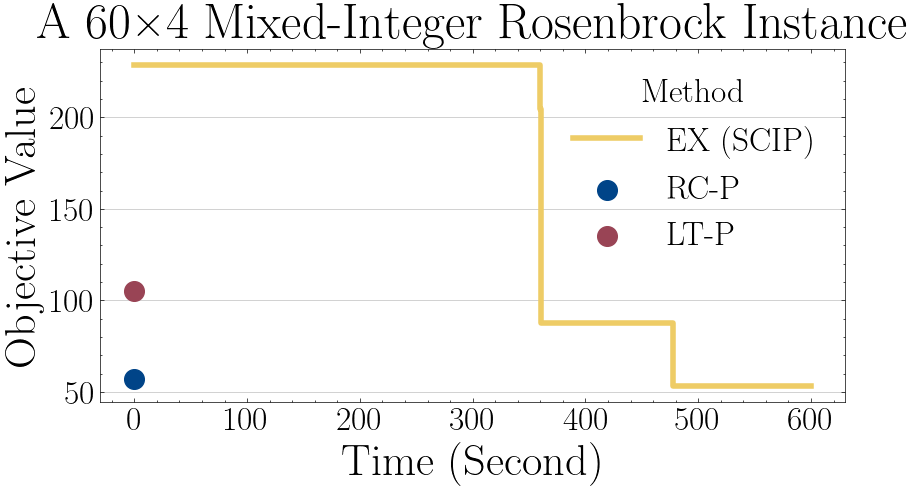

In [3]:
times = [0, 360, 361, 478, 600] 
objs = [2.286008e+02, 2.047632e+02, 8.781154e+01, 5.331860e+01, 5.331860e+01]
plotObj(times, objs)